In [1]:
#installing the transformers library
!pip install transformers

In [2]:
#importing the pretrained biobert tokenizer and the biobert model
from transformers import AutoTokenizer, TFAutoModel
biobert_tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/BioRedditBERT-uncased")

biobert_model = TFAutoModel.from_pretrained("cambridgeltl/BioRedditBERT-uncased")

In [3]:
#displaying biobert model summary
biobert_model.summary()

**Dataset Creation**

In [ ]:
#mounting google drive data
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

Mounted at /content/drive/


In [ ]:
#setting os path
import os
os.chdir('/content/drive/MyDrive/ChatBot/Data')

In [ ]:
#loading the json medical data files
import json
with open('ehealthforumQAs.json') as f1:
  ehealth=json.load(f1)
with open('icliniqQAs.json') as f2:
  icliniq=json.load(f2)
with open('questionDoctorQAs.json') as f3:
  questiondoctor=json.load(f3)
with open('webmdQAs.json') as f4:
  webmd=json.load(f4)

In [ ]:
#function to extract question,answer and tags from the json objects
def extract_answer_question_tags(json_data):
  questions=[]
  answers=[]
  tags=[]
  for i in json_data:
    questions.append(i['question'])
    answers.append(i['answer'])
    tags.append(i['tags'])
  return questions,answers,tags

In [ ]:
#extracting the question,answer and tags from the medical json objects
all_questions=[]
all_answers=[]
all_tags=[]
for i in [ehealth,icliniq,questiondoctor,webmd]:
  questions,answers,tags=extract_answer_question_tags(i)
  all_questions.extend(questions)
  all_answers.extend(answers)
  all_tags.extend(tags)
print(len(all_questions),len(all_answers),len(all_tags))

29752 29752 29752


In [ ]:

#loading and storing the medical data into dataframe and csv file correspondingly.
import pandas as pd
all_data=pd.DataFrame({'questions':all_questions,'answers':all_answers,'tags':all_tags})
all_data.to_csv('all_data.csv',index=False)

In [ ]:
#loading medical data from the disk
all_data=pd.read_csv('all_data.csv')

In [ ]:
import re
import numpy as np
#function to preprocess tags post loading from disk
def preprocess_tags(tags):
  tags=tags[1:-1]
  tags=tags.replace("\'",'')
  return np.array(tags.split(', '))

In [ ]:
#preprocessing the tags post loading from disk
all_data['tags']=all_data.tags.apply(lambda x: preprocess_tags(x))

In [4]:
import re
#preprocessing questions and answers.
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def preprocess(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


all_data['preprocessed_question'] = all_data['questions'].apply(preprocess)
all_data['preprocessed_answer'] = all_data['answers'].apply(preprocess)
all_data.head()

In [ ]:
#finding the lens of preprocessed questions and answers
all_data['question_len']=all_data['preprocessed_question'].apply(lambda x: len(x.split(' ')))
all_data['answer_len']=all_data['preprocessed_answer'].apply(lambda x: len(x.split(' ')))

In [ ]:
#since more than 100% percent of questions and about 99% of all answers lie within 500 words, we use 500 as the max length
all_data['short_question']=all_data.apply(lambda x: ' '.join(x.preprocessed_question.split(' ')[:500]) if x.question_len>500 else x.preprocessed_question ,axis=1)
all_data['short_answer']=all_data.apply(lambda x: ' '.join(x.preprocessed_answer.split(' ')[:500]) if x.answer_len>500 else x.preprocessed_answer ,axis=1)

In [ ]:
#preparing the positive label dataset by taking the original question and original answer
all_dataset=all_data[['short_question','short_answer','tags']].copy()
all_dataset['label']=1.0

In [ ]:
#function to extract the negative samples using tags
def extract_negative_samples(question,tags):
  stop=False
  while (not stop):
    sample_row= all_dataset.sample()
    sample_tags=sample_row.tags.values[0]
    inter_tags=set(tags[0]).intersection(set(sample_tags))
    if len(inter_tags)==0:
      stop=True
  return sample_row

In [5]:
#preparing the negative labelled dataset
from tqdm.notebook import tqdm
tqdm.pandas()
negative_labels=all_dataset.progress_apply(lambda x: pd.Series([x.short_question,extract_negative_samples(x.short_question,x.tags).short_answer.values[0],x.tags]),axis=1)
negative_labels['label']=-1.0
negative_labels.columns=['short_question','short_answer','tags','label']

In [ ]:
#concatenating the positive and negative labelled dataset to get the final labelled dataset.
all_data_with_labels=pd.concat([all_dataset,negative_labels],axis=0)
all_data_with_labels.shape

(59504, 4)

In [ ]:
#splitting the data into train and validation
from sklearn.model_selection import train_test_split
train, validation = train_test_split(all_data_with_labels, test_size=0.2,random_state=42,shuffle=True,stratify=all_data_with_labels.label)

In [ ]:
#saving train and validation data to disk
train.to_csv('train_data_chatbot.csv',index=False)
validation.to_csv('validation_data_chatbot.csv',index=False)

In [ ]:
#loading train and validation data from disk
import pandas as pd
train=pd.read_csv('train_data_chatbot.csv')
validation=pd.read_csv('validation_data_chatbot.csv')

In [ ]:
#extracting the short answers and questions from the train data
questions=train['short_question']
answers=train['short_answer']
labels=train['label']

In [ ]:
#https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html
#Setting Max_length to be 512 as discussed above
MAX_LENGTH = 512
import tensorflow as tf


# Tokenize, filter and pad sentences
def tokenize_and_filter(questions, answers):
  tokenized_questions, tokenized_answers = [], []
  
  for (question, answer) in zip(questions, answers):
    # generating sequences
    tokenized_question =  biobert_tokenizer.encode(question)
    tokenized_answer = biobert_tokenizer.encode(answer)
    tokenized_questions.append(tokenized_question)
    tokenized_answers.append(tokenized_answer)

  # padding the sequences
  tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_questions, maxlen=MAX_LENGTH, padding='post')
  tokenized_answers = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_answers, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_questions, tokenized_answers

#tokenizing and padding the train questions and answers
questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
#preparing the question mask and the answer mask of the train dataset
train_question_mask=[[1 if token!=0 else 0 for token in question] for question in questions]
train_answer_mask=[[1 if token!=0 else 0 for token in answer] for answer in answers]

In [ ]:
#extracting the short answers and questions from the validation data
val_questions=validation['short_question']
val_answers=validation['short_answer']
val_labels=validation['label']

In [ ]:
#tokenizing and padding the validation question and answers
val_questions, val_answers = tokenize_and_filter(val_questions, val_answers)

In [ ]:
#preparing the question and answer mask for the validation data
val_question_mask=[[1 if token!=0 else 0 for token in question] for question in val_questions]
val_answer_mask=[[1 if token!=0 else 0 for token in answer] for answer in val_answers]

In [ ]:
#https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html
#preparing the training  dataset
import tensorflow as tf
BATCH_SIZE = 2
BUFFER_SIZE = 20000
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': questions,
        'answer': answers,
        'question_mask':train_question_mask,
        'answer_mask':train_answer_mask
    },
    {
        'label': labels.values
    },
))

# dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html
#preparing the validation dataset
import tensorflow as tf
BATCH_SIZE = 2
BUFFER_SIZE = 20000
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': val_questions,
        'answer': val_answers,
        'question_mask':val_question_mask,
        'answer_mask':val_answer_mask
    },
    {
        'label': val_labels.values
    },
))

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
#creating the ffn layer 
#https://github.com/ash3n/DocProduct/blob/master/docproduct/models.py
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate,Conv1D,MaxPool1D,Dropout
class FFN(tf.keras.layers.Layer):
    def __init__(
            self,
            name='FFN',
            **kwargs):
        """Simple Dense wrapped with various layers
        """

        super(FFN, self).__init__(name=name, **kwargs)
        self.dropout = 0.2
        self.ffn_layer = tf.keras.layers.Dense(
            units=768,
            activation='relu',
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')
        

    def call(self, inputs):
        ffn_embedding = self.ffn_layer(inputs)
        ffn_embedding = tf.keras.layers.Dropout(
            self.dropout)(ffn_embedding)
        ffn_embedding += inputs
        return ffn_embedding

In [7]:
#displaying the biobert model summary
biobert_model.summary()

In [ ]:
#creating the medicalbert model
#https://github.com/ash3n/DocProduct/blob/master/docproduct/models.py
class MedicalQAModelwithBert(tf.keras.Model):
    def __init__(
            self,
            trainable=False,
            name=''):
        super(MedicalQAModelwithBert, self).__init__(name=name)

        self.q_ffn_layer = FFN(name='q_ffn')
        self.a_ffn_layer = FFN(name='a_ffn')
        self.biobert_model=biobert_model
        self.biobert_model.trainable=trainable
        self.cos=tf.keras.layers.Dot(axes=1,normalize=True)

    def call(self, inputs):
      question_embeddings=self.biobert_model(input_ids=inputs['question'],attention_mask=inputs['question_mask']).pooler_output
      answer_embeddings=self.biobert_model(input_ids=inputs['answer'],attention_mask=inputs['answer_mask']).pooler_output
      q_ffnn=self.q_ffn_layer(question_embeddings)
      a_ffnn=self.a_ffn_layer(answer_embeddings)
      output=self.cos([q_ffnn,a_ffnn])
      return {"label":output}

In [ ]:
#defining custom callback
class custom_callback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'acc': []}

  def on_epoch_end(self, epoch, logs={}):
        self.history['acc'].append(logs.get('custom_metric_acc'))
  


        #saving the model if validation accuracy increased from previous epoch
        if  (epoch==0) or (logs.get('custom_metric_acc')>self.history['acc'][epoch-1]):
          self.model.save_weights('medical_bert_re'+str(epoch)+'/medic'+str(epoch)+'_'+str(logs.get('custom_metric_acc')))


        is_nan_values=[]
        for i in self.model.get_weights():
          is_nan_values.append(np.isnan(i).any())

        #stopping the training if weights is nan or loss is nan or inf
        if (np.array(is_nan_values).any() or (tf.math.is_nan(logs.get('loss'))) or (np.isinf(logs.get('loss')))):
          self.model.stop_training = True

In [ ]:
#defining the custom metric
batch_size=2
def custom_metric_acc(y_true,y_pred):
  y_true=tf.reshape(y_true,[tf.constant(batch_size)])
  y_pred=tf.reshape(y_pred,[tf.constant(batch_size)])
  c=tf.constant(0,dtype='float32')
  d=tf.cast(tf.math.greater_equal(y_true,c),dtype='float32')
  e=tf.cast(tf.math.greater_equal(y_pred,c),dtype='float32')
  f=tf.cast(tf.math.equal(d,e),dtype='float32')
  g=tf.reduce_sum(f)
  h=tf.cast(tf.shape(f),dtype='float32')
  i=g/h
  return i

In [8]:
#compiling and training the medical qa model
import tensorflow.keras.backend as K
K.set_floatx('float32')
learning_rate=5e-6
num_epochs=5
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
medical_qa_model=MedicalQAModelwithBert(trainable=True)
medical_qa_model.compile(
    optimizer=optimizer, loss=tf.keras.losses.mean_squared_error, metrics=[custom_metric_acc])

epochs = num_epochs

medical_qa_model.fit(dataset,validation_data=val_dataset,epochs=epochs,callbacks=[custom_callback()])
medical_qa_model.summary()

****Evaluating the model with the best train accuracy****

In [9]:
import tensorflow.keras.backend as K
K.set_floatx('float32')
medical_qa_model=MedicalQAModelwithBert(trainable=True)
medical_qa_model.load_weights('./medical_bert_re4/medic4_0.8965799808502197')
learning_rate=5e-6
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
medical_qa_model.compile(
    optimizer=optimizer, loss=tf.keras.losses.mean_squared_error, metrics=[custom_metric_acc])

# original_labels=[]
predicted_labels=[]
from tqdm.notebook import tqdm
for i in tqdm(range(len(val_questions))):
  predicted_labels.append(medical_qa_model.predict({'question':np.array([val_questions[i]]),'question_mask':np.array([val_question_mask[i]]),
                             'answer':np.array([val_answers[i]]),'answer_mask':np.array([val_answer_mask[i]])})['label'][0][0])

In [ ]:
#defining function to return accuracy, correctly predicted positive points and correctly predicted negative points
def acc_threshold(predicted_labels,threshold):
  correct_pred_pos=[]
  correct_pred_neg=[]
  for i in range(len(predicted_labels)):
    if predicted_labels[i]<threshold and val_labels[i]==-1:
      correct_pred_neg.append(predicted_labels[i])
    elif predicted_labels[i]>=threshold and val_labels[i]==1:
      correct_pred_pos.append(predicted_labels[i])
  acc=len(correct_pred_pos+correct_pred_neg)/len(predicted_labels)
  print('accuracy for threshold',threshold,'is',acc)
  return (acc,correct_pred_pos,correct_pred_neg)

In [ ]:
#function to print the best accuracy and the threshold at which it is occuring
def best_threshold_acc(predicted_labels):
  acc=[]
  thresholds=np.array(range(-10,11,1))*0.1
  for i in tqdm(range(-10,11,1)):
    acc.append(acc_threshold(predicted_labels,i*0.1)[0])
  print('best accuracy is',max(acc),'at threshold',thresholds[np.argmax(acc)])

In [10]:
#find best threshold and accuracy of the model with best train accuracy on validation data
best_threshold_acc(predicted_labels)

In [11]:
#find best threshold and accuracy of the model with best train accuracy on validation data
best_threshold_acc(predicted_labels)

accuracy for threshold 0.2 is 0.8261490631039409


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


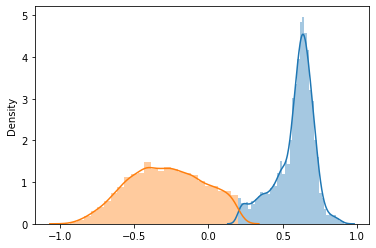

In [ ]:
#displaying the pdf of correctly predicted positive and negative points
import seaborn as sns
_,correct_pred_pos,correct_pred_neg=acc_threshold(predicted_labels,0.2)
sns.distplot(correct_pred_pos)
sns.distplot(correct_pred_neg)

**Evaluating the model with best validation accuracy**

In [12]:
#evaluating the model on validation data
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
K.set_floatx('float32')
medical_qa_model=MedicalQAModelwithBert(trainable=False)
medical_qa_model.load_weights('./medical_bert_re2/medic2_0.8574639558792114')
learning_rate=5e-6
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
predicted_labels=[]
from tqdm.notebook import tqdm
for i in tqdm(range(len(val_questions))):
  predicted_labels.append(medical_qa_model.predict({'question':np.array([val_questions[i]]),'question_mask':np.array([val_question_mask[i]]),
                             'answer':np.array([val_answers[i]]),'answer_mask':np.array([val_answer_mask[i]])})['label'][0][0])

In [13]:
#finding the best accuracy and the corresponding threshold of the model of best validation accuracy
best_threshold_acc(predicted_labels)

In [ ]:
train_predicted_labels=[]
for i in tqdm(range(len(questions))):
  train_predicted_labels.append(medical_qa_model.predict({'question':np.array([questions[i]]),'question_mask':np.array([train_question_mask[i]]),
                             'answer':np.array([answers[i]]),'answer_mask':np.array([train_answer_mask[i]])})['label'][0][0])

In [ ]:
#defining function to return accuracy, correctly predicted positive points and correctly predicted negative points for train data
def train_acc_threshold(predicted_labels,threshold):
  correct_pred_pos=[]
  correct_pred_neg=[]
  for i in range(len(predicted_labels)):
    if predicted_labels[i]<threshold and labels[i]==-1:
      correct_pred_neg.append(predicted_labels[i])
    elif predicted_labels[i]>=threshold and labels[i]==1:
      correct_pred_pos.append(predicted_labels[i])
  acc=len(correct_pred_pos+correct_pred_neg)/len(predicted_labels)
  print('accuracy for threshold',threshold,'is',acc)
  return (acc,correct_pred_pos,correct_pred_neg)

In [ ]:
#function to print the best accuracy and the threshold at which it is occuring for train points
def train_best_threshold_acc(predicted_labels):
  acc=[]
  thresholds=np.array(range(-10,11,1))*0.1
  for i in tqdm(range(-10,11,1)):
    acc.append(train_acc_threshold(predicted_labels,i*0.1)[0])
  print('best accuracy is',max(acc),'at threshold',thresholds[np.argmax(acc)])

In [ ]:
train_best_threshold_acc(train_predicted_labels)

accuracy for threshold -1.0 is 0.5000105035396929
accuracy for threshold -0.9 is 0.5001155389366216
accuracy for threshold -0.8 is 0.5038337919878999
accuracy for threshold -0.7000000000000001 is 0.5158078272377792
accuracy for threshold -0.6000000000000001 is 0.5431170304392581
accuracy for threshold -0.5 is 0.5889124635001995
accuracy for threshold -0.4 is 0.6438039619351722
accuracy for threshold -0.30000000000000004 is 0.7020145789130937
accuracy for threshold -0.2 is 0.7586286578576981
accuracy for threshold -0.1 is 0.8038148856164528
accuracy for threshold 0.0 is 0.84028317543012
accuracy for threshold 0.1 is 0.8690628741886015
accuracy for threshold 0.2 is 0.8901119677331261
accuracy for threshold 0.30000000000000004 is 0.8993340755834717
accuracy for threshold 0.4 is 0.8958469004054367
accuracy for threshold 0.5 is 0.8619204671974455
accuracy for threshold 0.6000000000000001 is 0.7061949877108585
accuracy for threshold 0.7000000000000001 is 0.5218368590214902
accuracy for thres

accuracy for threshold 0.3 is 0.8541299050499958


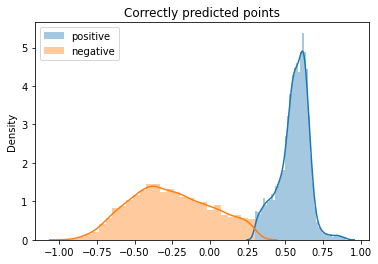

In [ ]:
#plotting the pdf of correctly predicted positive and negative points
import matplotlib.pyplot as plt
import seaborn as sns
_,correct_pred_pos,correct_pred_neg=acc_threshold(predicted_labels,0.3)
sns.distplot(correct_pred_pos,label='positive')
sns.distplot(correct_pred_neg,label='negative')
plt.title('Correctly predicted points')
plt.legend()
plt.show()

In [ ]:
#finding incorrectly predicted positive and negative points
incorrect_pos=[]
incorrect_neg=[]
for i in range(len(val_labels)):
  if val_labels[i]==1 and predicted_labels[i]<0.3:
    incorrect_pos.append(predicted_labels[i])
  elif val_labels[i]==-1 and predicted_labels[i]>=0.3:
    incorrect_neg.append(predicted_labels[i])

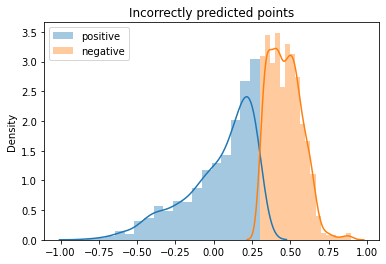

In [ ]:
#plotting the pdf of model predicted similarities for incorrectly predicted positive and negative points
sns.distplot(incorrect_pos,label='positive')
sns.distplot(incorrect_neg,label='negative')
plt.title('Incorrectly predicted points')
plt.legend()
plt.show()

**Embedding extraction using the model**

In [ ]:
#loading the trained medical bert model from above checkpoint
medical_qa_model=MedicalQAModelwithBert(trainable=True)
medical_qa_model.load_weights('./medical_bert_re2/medic2_0.8574639558792114')

In [ ]:
#defining the question extractor model
x1=tf.keras.layers.Input((512),name='question',dtype='int64')
x2=tf.keras.layers.Input((512),name='question_mask',dtype='int64')
q_embed=medical_qa_model.get_layer('q_ffn')(medical_qa_model.get_layer('tf_bert_model').bert(input_ids=x1,attention_mask=x2,).pooler_output)
question_extractor_model=tf.keras.Model(inputs=[x1,x2],outputs=q_embed)

In [ ]:
#saving the question extractor model to disk
question_extractor_model.save('question_extractor_model_2_11')

In [ ]:
#loading the question extractor model from disk
question_extractor_model=tf.keras.models.load_model('question_extractor_model_2_11')

In [ ]:
#function to extract embeddings given a question and a question mask
def question_extractor(sam_dict):
  q_embed=question_extractor_model({'question':sam_dict['question'],'question_mask':sam_dict['question_mask']})
  return q_embed

In [ ]:
#defining function to extract question embeddings given question
def extract_question_embed(question):
  max_length=512
  tokenized_questions=[]
  tokenized_question =  biobert_tokenizer.encode(question)
  tokenized_questions.append(tokenized_question)

  # padding the sequences
  tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_questions, maxlen=max_length, padding='post')
  attention_mask=[[1 if token>0 else 0 for token in q] for q in tokenized_questions]
  return question_extractor({'question':np.array(tokenized_questions),'question_mask':np.array(attention_mask)})

In [ ]:
#defining the answer extractor model
x1=tf.keras.layers.Input((512),name='answer',dtype='int64')
x2=tf.keras.layers.Input((512),name='answer_mask',dtype='int64')
a_embed=medical_qa_model.get_layer('a_ffn')(medical_qa_model.get_layer('tf_bert_model').bert(input_ids=x1,attention_mask=x2,).pooler_output)
answer_extractor_model=tf.keras.Model(inputs=[x1,x2],outputs=a_embed)

In [ ]:
#saving the answer extractor model to disk
answer_extractor_model.save('answer_extractor_model_2_13')

In [ ]:
#loading the answer extractor model from disk
answer_extractor_model=tf.keras.models.load_model('answer_extractor_model_2_13')

In [ ]:
#function to extract embeddings given an answer and an answer mask
def answer_extractor(sam_dict):
  a_embed=answer_extractor_model({'answer':sam_dict['answer'],'answer_mask':sam_dict['answer_mask']})
  return a_embed

In [ ]:
#defining function to extract answer embeddings
def extract_answer_embed(answer):
  max_length=512
  tokenized_answers=[]
  tokenized_answer =  biobert_tokenizer.encode(answer)
  tokenized_answers.append(tokenized_answer)

  # padding the sequences
  tokenized_answers = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_answers, maxlen=max_length, padding='post')
  attention_mask=[[1 if token>0 else 0 for token in q] for q in tokenized_answers]
  return answer_extractor({'answer':np.array(tokenized_answers),'answer_mask':np.array(attention_mask)})

In [ ]:
#extracting the original(without negative sampling) train dataset
pos_train=train[train.label==1.0].copy()
pos_train.shape

In [ ]:
#extracting the original(without negative sampling) validation dataset
pos_validation=validation[validation.label==1.0].copy()
pos_validation.shape

In [ ]:
#extracting the question embeddings of train data
from tqdm.notebook import tqdm
tqdm.pandas()
pos_train['short_question_embed']=pos_train.short_question.progress_apply(lambda x: extract_question_embed(x))

In [ ]:
#extracting the question embeddings of validation data
pos_validation['short_question_embed']=pos_validation.short_question.progress_apply(lambda x: extract_question_embed(x))

In [ ]:
#extracting the answer embeddings of train data
pos_train['short_answer_embed']=pos_train.short_answer.progress_apply(lambda x: extract_answer_embed(x))

In [ ]:
#extracting the answer embeddings of validation data
pos_validation['short_answer_embed']=pos_validation.short_answer.progress_apply(lambda x: extract_answer_embed(x))

In [ ]:
#converting embeddings from tensors to numpy arrays
pos_train['short_answer_embed_numpy']=pos_train.short_answer_embed.apply(lambda x: x.numpy() )
pos_train['short_question_embed_numpy']=pos_train.short_question_embed.apply(lambda x: x.numpy())

In [ ]:
#converting embeddings from tensors to numpy arrays
pos_validation['short_answer_embed_numpy']=pos_validation.short_answer_embed.apply(lambda x: x.numpy() )
pos_validation['short_question_embed_numpy']=pos_validation.short_question_embed.apply(lambda x: x.numpy())

In [ ]:
#Saving train question and answer embeddings to disk
pos_train.drop(['short_answer_embed','short_question_embed'],axis=1).to_csv('re_train_embeds.csv',index=False)

In [ ]:
#saving validation question and answer embeddings to disk
pos_validation.drop(['short_answer_embed','short_question_embed'],axis=1).to_csv('re_validation_embeds.csv',index=False)